## Исследование клиентов супермаркета

Работу выполнили студенты 4 подгруппы групп 21УБ3 и 21УБ5:
* Седюк Марк Романович (*21УБ5*)
* Босов Роман Андреевич (*21УБ5*)
* Божатков Александр Дмитриевич (*21УБ5*)
* Маковей Степан Алексеевич (*21УБ3*)

### План действий
1. **Описание проекта**
1.1. Бизнес-постановка задачи
1.2. Постановка задачи анализа данных
1.3. Источник данных
1.4. Обзор доступных данных
2. **Загрузка и импорт библиотек**
3. **Загрузка датасета**
4. **Оптимизация данных для анализа**
5. **Проверка пропущенных значений**
6. **Проверка типов данных**
7. **Построение графиков для поиска зависимостей уровня Spending Score от остальных признаков**
8. **Кластерный анализ**
8.1. One-hot кодирование
8.2. K-means
8.3. Агломеративная иерархическая кластеризация
9. **Общие выводы по проекту и рекомендации к исследованию**


### Шаг 1. Описание проекта

#### Бизнес-постановка задачи
Магазины для персонализированного маркетинга сегментируют клиентуру, исходя из их дохода, возраста и поведения. Задача сегментации аудитории может быть нужна для:
* Выявления целевых групп для определенных товаров;
* Предоставления релевантных для определенных групп специальных предложений;
* Определения ценовой политики фирмы;
* Выявления дополнительных признаков для будущих задач машинного обучения, связанных с анализом поведения клиентов;
* Дальнейшего изучения аудитории.

#### Постановка задачи анализа данных
Целью данной задачи является сегментация групп покупателей магазина с помощью проведения разведочного анализа данных и кластерного анализа. Набор данных состоит из сгенерированных характеристик покупателей магазина и их клиентского поведения.

#### Источник данных
Данные предоставлены в форме таблицы csv, приложенной к заданию. Данные также загружены на dropbox по [ссылке](https://www.dropbox.com/s/gyl7hqp9d7pnsme/Mall_Customers.csv?dl=0).

Данные опубликованы в открытом доступе на платформе Kaggle и доступны по [ссылке](https://www.kaggle.com/datasets/shwetabh123/mall-customers).

#### Обзор доступных данных
В выборке 204 наблюдения и 5 переменных. Однако, так как столбец CustomerID по сути является индексным и не представляет ценности для анализа, то его нужно исключить из списка признаков. Таким образом, про каждый из 204 клиентов мы знаем значения 4 их характеристик (пол, возраст, годовой доход и оценка расходов).

Признаки:
* **CustomerID**: Unique ID assigned to the customer *(уникальный идентификатор покупателя)*;
* **Gender**: Gender of the customer *(пол покупателя)*;
* **Age**: Age of the customer *(возраст покупателя)*;
* **Annual Income (k$)**: Annual Income of the customer *(годовой доход покупателя в тысячах долларов)*;
* **Spending Score (1-100)**: Score assigned by the mall based on customer behavior and spending nature *(оценка расходов покупателя, определенная магазином на основе поведения и трат покупателя, изменяется от 1 до 100)*.


Так как мы решаем задачу кластеризации, то мы не выделяем в данных целевой переменной. Так как кластеризация - задача обучения без учителя, то выборку не нужно разбивать на тестовую и обучающую.

### Шаг 2. Загрузка и импорт библиотек

Библиотека для фильтрации выводимых пользователю предупреждений.

In [70]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Общепринятые библиотеки для работы с табличными данными.

In [71]:
import numpy as np
import pandas as pd

Средства визуализации.

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

Библиотека для регулярных выражений (нужна для предварительной обработки названий столбцов).

In [73]:
import re

Инструменты для кластеризации, визуализации кластеров и оценки метрик кластеризации.

In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

### Шаг 3. Загрузка датасета

Загружаем датасет из dropdox по [ссылке](https://www.dropbox.com/s/gyl7hqp9d7pnsme/Mall_Customers.csv?dl=0). Для загрузки по ссылке ставим в ссылке `dl=0`. Так как в предоставленной csv таблице в качестве разделителя использован символ `';'`, то указываем `delimeter=";"`

In [75]:
data = pd.read_csv("https://www.dropbox.com/s/gyl7hqp9d7pnsme/Mall_Customers.csv?dl=1", delimiter=";")

Проверяем, что данные загрузились и правильно отображаются. смотрим размер таблицы.

In [76]:
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
199,196,Female,35,120,79
200,197,Female,45,126,28
201,198,Male,32,126,74
202,199,Male,32,137,18


In [77]:
print(data.shape)

(204, 5)


### Шаг 4. Оптимизация данных для анализа

В первую очередь удаляем индексный столбец `CustomerID`.

In [78]:
data = data.drop('CustomerID', axis=1)

Удаляем выражения в скобках из названий столбцов.

In [79]:
data.columns = [re.sub(r"\(+.*\)+", '', s) for s in data.columns]

Для удобства дальнейшей работы удаляем лишние пробелы в начале и в конце названий столбцов, а также приводим все названия столбцов к принятому в Python *snake_case* (нижний регистр с подчеркиваниями).

In [80]:
data.columns = [s.strip().lower().replace(' ', '_') for s in data.columns]

In [81]:
data.head()

,gender,age,annual_income,spending_score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


### Шаг 5. Проверка пропущенных значений

Проверяем наличие пропусков в табличных данных.

In [82]:
data.isna().sum()

gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

**Пропуски отсутствуют.**

Теперь проверим есть ли нули и неопределенные значения.

In [83]:
print(data.gender.unique())

['Male' 'Female']


 В колонке `gender` неопределенных категорий нет.

In [84]:
data[data.spending_score == 0]

,gender,age,annual_income,spending_score
17,Female,0,21,0
20,Male,55,23,0
133,Male,0,0,0


`Spending score` не может иметь значение 0, так как он изменяется строго от 1 до 100. Также заметим, что в колонке `age` в части этих записей стоят нули, что тоже является пропуском, так как возраст покупателя не может быть равен нулю. Так как нулевых значений только 3, то можно просто удалить строки с нулевыми значениями.

In [85]:
data = data.drop([17, 20, 133])

Проверим, что в данных не осталось объектов с `age=0`.

In [86]:
data[data.age == 0]

,gender,age,annual_income,spending_score


Все нулевые значения возраста уже были удалены.

In [87]:
data[data['annual_income'] == 0]

,gender,age,annual_income,spending_score
144,Female,20,0,11


В теории у человека может быть нулевой доход, поэтому данную запись оставим.

### Шаг 6. Проверка типов данных

Выведем типы данных в столбцах.

In [88]:
data.dtypes

gender            object
age                int64
annual_income      int64
spending_score     int64
dtype: object

Числовые типы данных соответствуют столбцам с числовыми данными, а категориальный признак `gender` соответствует столбцу с типом `object` - все верно.

Выведем максимальные и минимальные значения в каждой из числовых колонок и проверим, что значения в числовых колонках лежат в рациональных границах (например, что нет отрицательных значений возраста или `Spending Score` > 100).

In [89]:
print(f"{data['spending_score'].min()} <= Spending Score <= {data['spending_score'].max()}")
print(f"{data['age'].min()} <= Age <= {data['age'].max()}")
print(f"{data['annual_income'].min()} <= Annual Income <= {data['annual_income'].max()}")

1 <= Spending Score <= 99
18 <= Age <= 70
0 <= Annual Income <= 137


Все значения реалистичны и подходят под ограничения.

Заметим, что значения всех трех числовых колонок принимают не очень большие значения (от 0 до 137), однако тип этих колонок - `int64` (длинное целое). Для ускорения работы с таблицей можно сжать числовые типы до более коротких.

In [90]:
data['age'] = pd.to_numeric(data['age'], downcast='integer')
data['annual_income'] = pd.to_numeric(data['annual_income'], downcast='integer')
data['spending_score'] = pd.to_numeric(data['spending_score'], downcast='integer')

In [91]:
data.dtypes

gender            object
age                 int8
annual_income      int16
spending_score      int8
dtype: object

В нашем случае из-за небольшого размера таблицы ускорение будет незаметно, однако при больших размерах таблицы *downcast* числовых значений позволил бы сэкономить время и память.

### Шаг 7. Сжатие 100-балльной шкалы в 3-балльную

Напишем функцию для преобразования 100-балльной шкалы в трехбалльную.
1 - низкий уровень трат (Spending Score);
2 - средний уровень трат (Spending Score);
3 - высокий уровень трат (Spending Score).

In [92]:
def GetRank(score):
    ranks = list(range(1, 4))
    return ranks[min(max(int(score / (100 / 3)), 0), 2)]

Сгруппируем данные по уровню трат и посмотрим на количество объектов в у каждого из трех уровней.

In [93]:
data.groupby(by = data.spending_score.map(GetRank)).count()

,gender,age,annual_income,spending_score
spending_score,,,,
1,50,50,50,50
2,94,94,94,94
3,57,57,57,57


Заметим, что клиенты со средним Spending Score преобладают, что соответствует нормальному распределению.

Добавим столбец `spending_rank` с трехбалльной шкалой уровня трат.

In [94]:
data = data.assign(spending_rank = (data.spending_score.map(GetRank)))

In [95]:
data.head()

,gender,age,annual_income,spending_score,spending_rank
0,Male,19,15,39,2
1,Male,21,15,81,3
2,Female,20,16,6,1
3,Female,23,16,77,3
4,Female,31,17,40,2


### Шаг 8. Поиск зависимостей высокого, низкого и среднего Spending Score от остальных признаков

#### 0. Построим матрицу корреляции для всех признаков

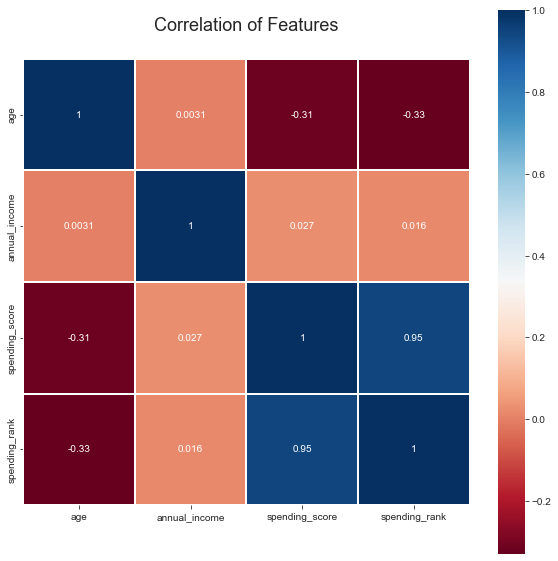

In [96]:
# Для того чтобы лучше понимать связь признаков с целевой переменной, построим карту корреляции
colormap = plt.cm.RdBu
plt.figure(figsize=(10,10))

plt.title('Correlation of Features', y=1.05, size=18)
sns.heatmap(data.corr(),
            linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

##### Выводы:
* Линейной зависимости Spending Score от дохода нет;
* Возраст коррелирует с Spending Score: Spending Score обратно пропорционален возрасту, то есть при росте возраста Spending Score в основном снижается.

#### 1. Построим гистограмму зависимости высокого, низкого и среднего Spending Score от годового дохода

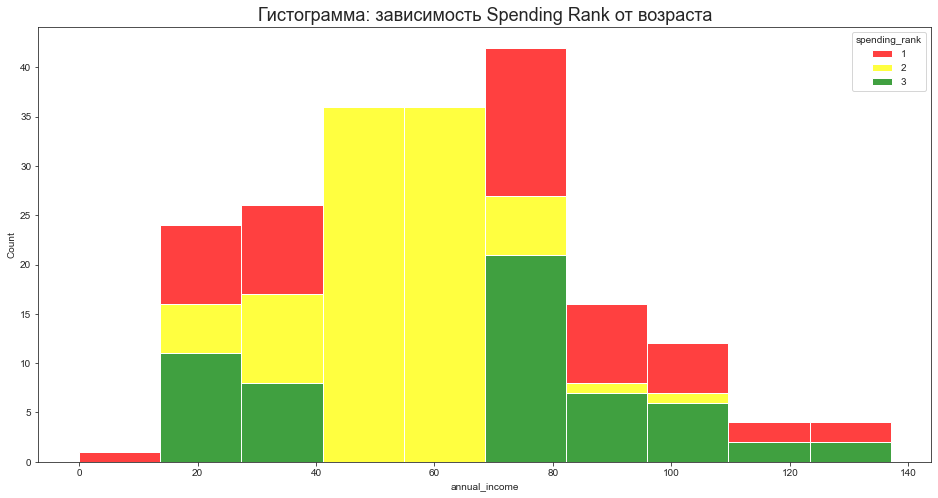

In [97]:
# Зададим размеры и стиль фигуры
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Гистограмма: зависимость Spending Rank от возраста', fontsize=18)
# Строим график
sns.histplot(data, x='annual_income', hue='spending_rank', multiple="stack", bins=10,
              ax=ax, palette=[ 'red', 'yellow', 'green']);

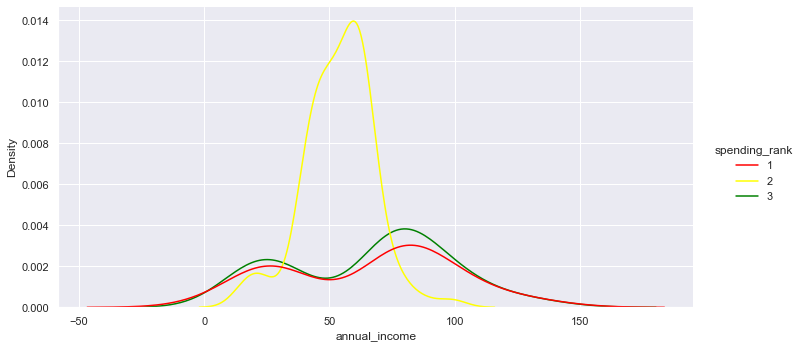

In [124]:
sns.displot(data, x='annual_income', hue='spending_rank', kind='kde', palette=[ 'red', 'yellow', 'green'], height=5, aspect=2);

##### Выводы:
* Все люди с доходом от 40 до 70 тысяч долларов в год имеют средний Spending Score;
* Высокий Spending Score преобладает у клиентов с доходом около 20 тысяч и от 70 до 80 тысяч, однако для этих категорий примерно с 30-процентной вероятностью может быть и низкий Spending Score;
* У людей с доходом от 30 до 40 тысяч с равной вероятностью может быть любой Spending Score;
* При доходе более 80-тысяч Spending Score с одинаковой вероятностью либо высокий, либо низкий (средний очень маловероятен).

**Итог:**
Доход позволяет нам четко выделить основную группу со средним Spending Score (клиенты в ней имеют средний доход около 50 тысяч) и утверждать, что среднего Spending Score не может быть при большом доходе. Низкий и высокий Spending Score разделить исходя из дохода затруднительно.

#### 2. Построим гистограмму зависимости высокого, низкого и среднего Spending Score от пола

In [99]:
data.groupby("gender").count()

,age,annual_income,spending_score,spending_rank
gender,,,,
Female,113,113,113,113
Male,88,88,88,88


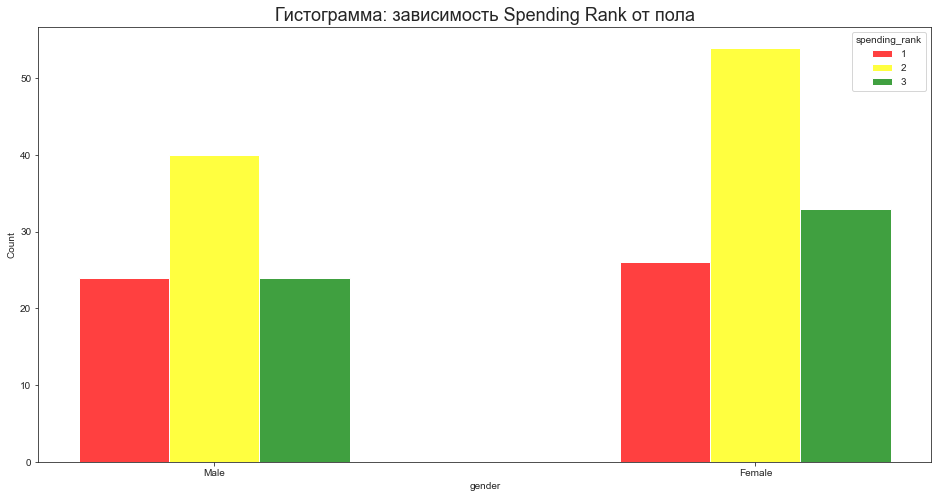

In [100]:
# Зададим размеры и стиль фигуры
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Гистограмма: зависимость Spending Rank от пола', fontsize=18)
# Строим график
sns.histplot(data, x='gender', hue='spending_rank', multiple="dodge",
             shrink = 0.5, ax=ax, palette=[ 'red', 'yellow', 'green']);

##### Выводы:
* Независимо от пола преобладает средний Spending Score;
* Среди мужчин и женщин равное число клиентов с низким Spending Score;
* Число мужчин с высоким и низким Spending Score одинаковое;
* Женщин с высоким и средним Spending Score больше, чем мужчин, однако причина этого в дисбалансе классов пола.

**Итог:**
Покупателей-женщин больше, чем мужчин. Женщины с большей вероятностью, чем мужчины имеют средний Spending Score.

#### 3. Построим гистограммы зависимости высокого, низкого и среднего Spending Score от возраста

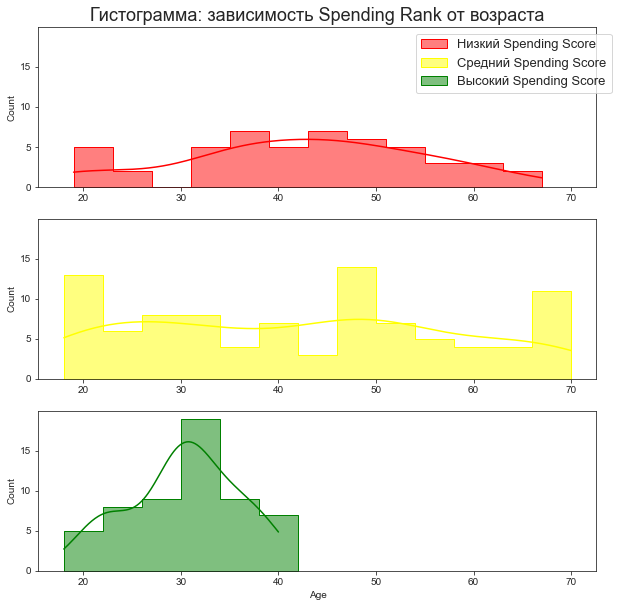

In [101]:
# Зададим размеры и стиль фигуры, количество графиков
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].set_title('Гистограмма: зависимость Spending Rank от возраста', fontsize=18)
sns.set_style(style="ticks")

# Строим первый график
plt.subplot(3, 1, 1)
sns.histplot(data=data[data.spending_rank==1], x='age', color='red', binwidth=4, element='step', label='Низкий Spending Score', kde=True)
plt.xlabel('')

# Строим второй график
plt.subplot(3, 1, 2)
sns.histplot(data=data[data.spending_rank==2], x='age', color='yellow', binwidth=4, element='step', label='Средний Spending Score', kde=True)
plt.xlabel('')

# Строим третий график
plt.subplot(3, 1, 3)
sns.histplot(data=data[data.spending_rank==3], x='age', color='green',binwidth=4, element='step', label='Высокий Spending Score', kde=True)
plt.xlabel('Age')

# Установим одинаковые пределы вертикальных осей на трех графиках
max_ylim = max(axs[0].get_ylim(), axs[1].get_ylim(), axs[2].get_ylim())
axs[0].set_ylim(max_ylim)
axs[1].set_ylim(max_ylim)
axs[2].set_ylim(max_ylim)

# Установим одинаковые пределы горизонтальных осей на трех графиках
max_xlim = (min(axs[0].get_xlim()[0], axs[1].get_xlim()[0], axs[2].get_xlim()[0]), max(axs[0].get_xlim()[1], axs[1].get_xlim()[1], axs[2].get_xlim()[1]))
axs[0].set_xlim(max_xlim)
axs[1].set_xlim(max_xlim)
axs[2].set_xlim(max_xlim)

# Добавим легенду
fig.legend(bbox_to_anchor=(0.93, 0.88), fontsize=13)

plt.show()

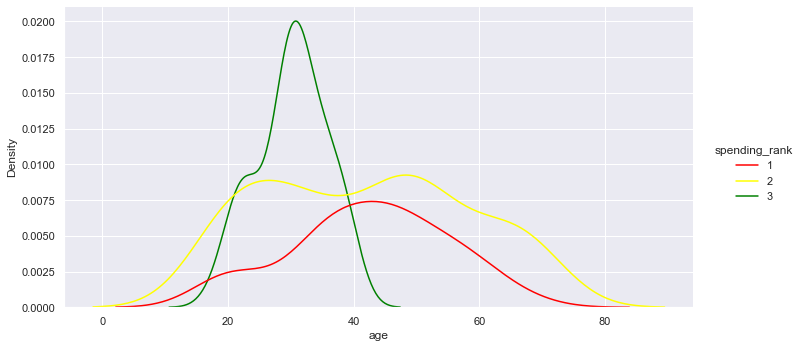

In [125]:
sns.displot(data, x='age', hue='spending_rank', kind='kde', palette=[ 'red', 'yellow', 'green'], height=5, aspect=2)
plt.show()

##### Выводы:
* Для молодежи от 18 до 21 года характерен средний Spending Score;
* Высокий Spending Score преобладает у людей в возрасте от 29 до 33 лет;
* У людей от 35 до 45 чаще всего встречается низкий Spending Score;
* У клиентов от 46 до 50 лет в основном средний Spending Score;
* У клиентов от 51 до 65 лет с примерно равной вероятностью может быть как низкий, так и средний Spending Score;
* Для клиентов старше 65 лет в основном характерен средний Spending Score;
* Высокий Spending Score не наблюдается у людей старше 40 лет;
* Cредний Spending Score наблюдается во всех возрастных группах;
* Наиболее часто средний Spending Score встречается у клиентов в возрасте от 46 до 50 лет и молодежи от 18 до 21 года;
* Низкий Spending Score наиболее часто встречается у клиентов в возрасте около 35 лет.

**Итог:**
Таким образом, молодые люди и люди старше 45 в основном имеют средний Spending Score (иногда низкий), тогда как высокий Spending Score характерен для клиентов от 29 до 33 лет.
Возраст позволяет нам определить может у человека быть высокий Spending Score или нет. Низкий и средний Spending Score разделить исходя из возраста затруднительно.

### 4. Построим Violin Plot зависимости низкого и высокого Spending Score от дохода и пола

На одном из предыдущих этапов мы выделили средний Spending Score по доходу. Попробуем разделить высокий и низкий Spending Score с помощью дохода и пола.

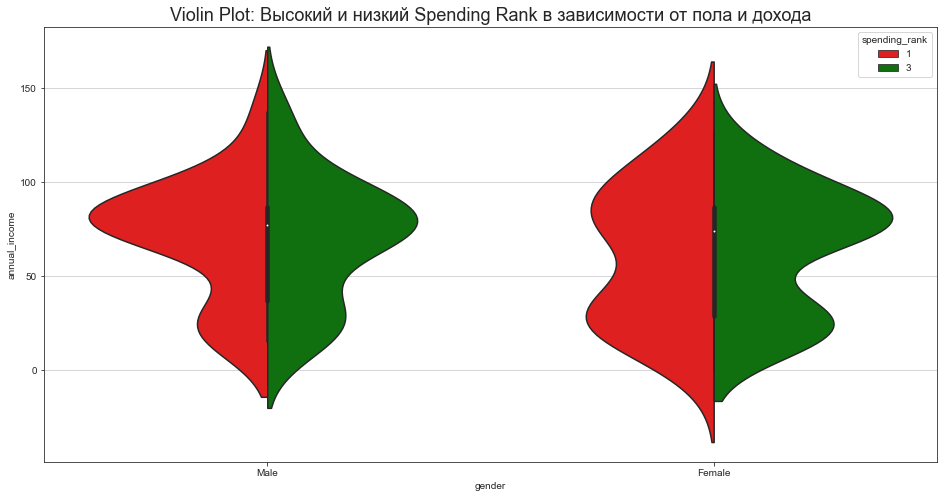

In [103]:
# Зададим размеры и стиль фигуры
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Violin Plot: Высокий и низкий Spending Rank в зависимости от пола и дохода', fontsize=18)
sns.set_style(style="white")
plt.grid(visible=True)

# Строим график
sns.violinplot(data=data[data['spending_rank'] != 2], x='gender', y='annual_income', hue='spending_rank',
               split=True, palette=['red', 'green'], ax=ax);


##### Выводы:
* Среди клиентов с доходом до 40 тысяч вероятности высокого и низкого Spending Score одинаковы;
* При доходе от 70 до 100 тысяч среди мужчин преобладает низкий Spending Score, а среди женщин, напротив, преобладает высокий Spending Score.

**Итог:**
Женщины с доходом около 90 тысяч с большей вероятностью будут иметь высокий Spending Score, а мужчины с таким доходом - низкий Spending Score.

#### 5. Построим диаграмму рассеяния низкого, среднего и высокого Spending Score от дохода и возраста

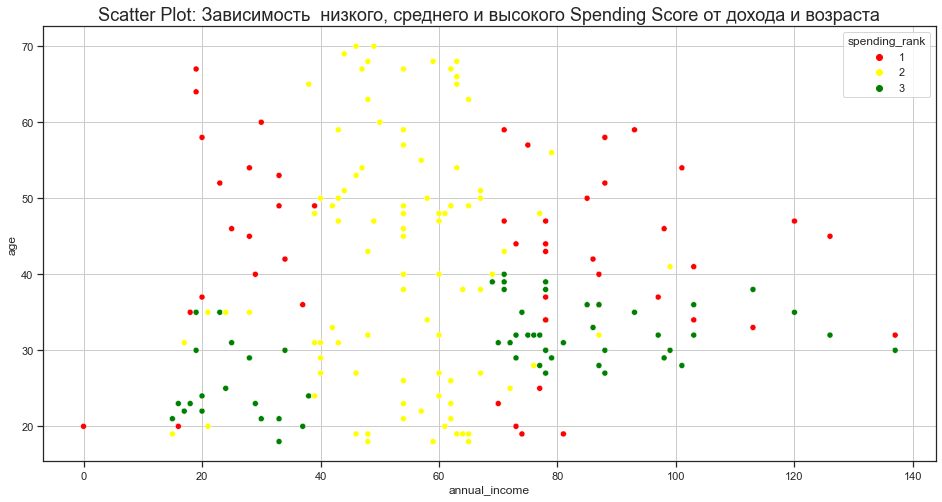

In [142]:
# Зададим размеры и стиль фигуры
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Scatter Plot: Зависимость  низкого, среднего и высокого Spending Score от дохода и возраста', fontsize=18)
ax.grid(True)
sns.set_style(style="ticks")

# Построим диаграмму рассеяния для уровней трат
sns.scatterplot(data=data, x="annual_income", y="age", hue="spending_rank", palette=['red', 'yellow', 'green']);

##### Выводы:
1. Высокий Spending Score:
* При доходе от 14 до 40 тысяч и возрасте от 18 до 31,
* При доходе выше 70 тысяч и возрасте от 27 до 40 лет;
2. Средний Spending Score:
* При доходе от 40 до 700 тысяч при любом возрасте;
3. Низкий Spending Score:
* При доходе от 15 до 40 тысяч и возрасте больше 35 лет,
* При доходе выше 70 тысяч и возрасте больше 35 лет;
* При доходе выше 70 тысяч и возрасте до 25 лет (маленькая область).

*Примечание: по возрасту и доходу можно лего построить решающее дерево, которое будет предсказывать низкий, средний и высокий Spending Score.*

### Шаг 9. Кластерный анализ

#### One-hot кодирование

In [105]:
data_1hot = pd.get_dummies(data, drop_first=True)
data_1hot.head()

,age,annual_income,spending_score,spending_rank,gender_Male
0,19,15,39,2,1
1,21,15,81,3,1
2,20,16,6,1,0
3,23,16,77,3,0
4,31,17,40,2,0


Убираем столбец `spending_rank`, так как он линейно зависит от `spending_score`

In [35]:
X = data_1hot.drop("spending_rank", axis=1)

X.head()

Нужно нормализовать данные, но по проведенным экспериментам модель кластеры на нормализованных данных сложно интерпретировать, поэтому было принято решение не применять нормализацию к данным.

#### K-means

Переберем несколько значений числа кластеров и выберем лучший по `silhouette_score`. Для каждого числа кластеров построим диаграмму-проекцию на плоскость признаков `annual_income` и `spending_score` (так как исходя из проделанных экспериментов, на этой плоскости лучше всего видны кластеры).

#### Метод локтя
WCSS(Within-Cluster-Sum-of-Squares) измеряет сумму расстояний наблюдений от их скоплений центроидов, которая определяется по приведенной ниже формуле.

C:\Users\ageev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


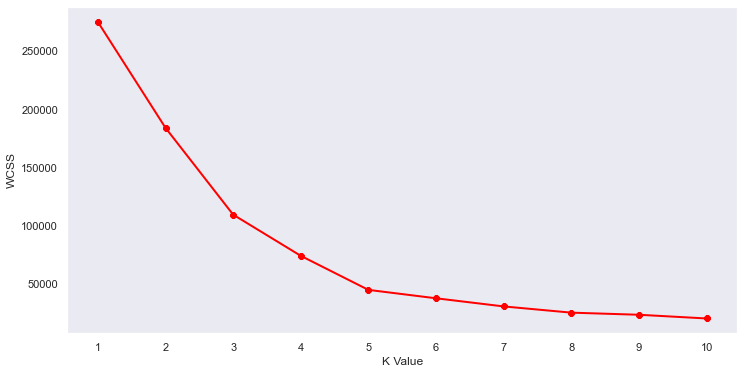

In [140]:
from sklearn.cluster import KMeans
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(X.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

Best score 0.451, k = 6


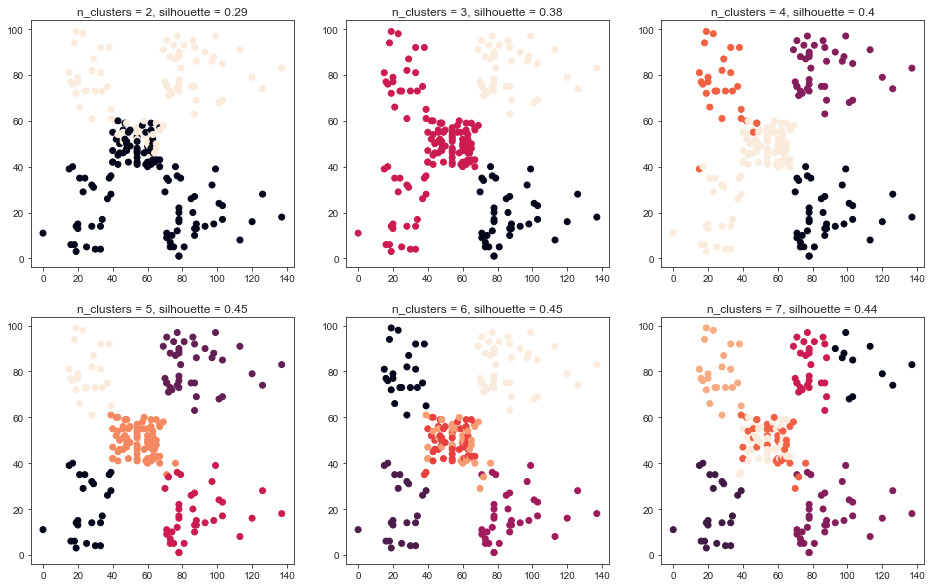

In [37]:
plt.figure(figsize=(16, 10))

best_k, best_score = None, -1

for k in range(2, 8):
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means = k_means.fit(X)
    clusters = k_means.labels_
    plt.subplot(2, 3, k - 1)
    plt.scatter(X["annual_income"], X["spending_score"], c=clusters)
    score = silhouette_score(X=X, labels=clusters)

    if score > best_score:
        best_score = score
        best_k = k

    plt.title(f'n_clusters = {k}, silhouette = {np.round(score, 2)}')
print(f'Best score {best_score:.3f}, k = {best_k}')
plt.show()

Лучший `silhouette` был получен при числе кластеров, равном 6, для этого числа кластеров проведем кластеризацию.

In [38]:
k_means = KMeans(n_clusters = 6, random_state=42)
k_means = k_means.fit(X)

clusters = k_means.labels_

Построим проекции кластеров на плоскость каждой пары признаков.

In [39]:
def print_cluster_projections(df, cs):
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 3, 1)
    plt.scatter(df["annual_income"], df["spending_score"], c = cs)
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')

    plt.subplot(2, 3, 2)
    plt.scatter(df["age"], df["spending_score"], c = cs)
    plt.xlabel('Age')
    plt.ylabel('Spending Score')

    plt.subplot(2, 3, 3)
    plt.scatter(df["age"], df["annual_income"], c = cs)
    plt.xlabel('Age')
    plt.ylabel('Annual Income')

    plt.subplot(2, 3, 4)
    plt.scatter(df["age"], df["gender_Male"], c = cs)
    plt.xlabel('Age')
    plt.ylabel('Gender')

    plt.subplot(2, 3, 5)
    plt.scatter(df["annual_income"], df["gender_Male"], c = cs)
    plt.xlabel('Annual Income')
    plt.ylabel('Gender')

    plt.subplot(2, 3, 6)
    plt.scatter(df["spending_score"], df["gender_Male"], c = cs)
    plt.xlabel('Annual Income')
    plt.ylabel('Gender')

    plt.show()

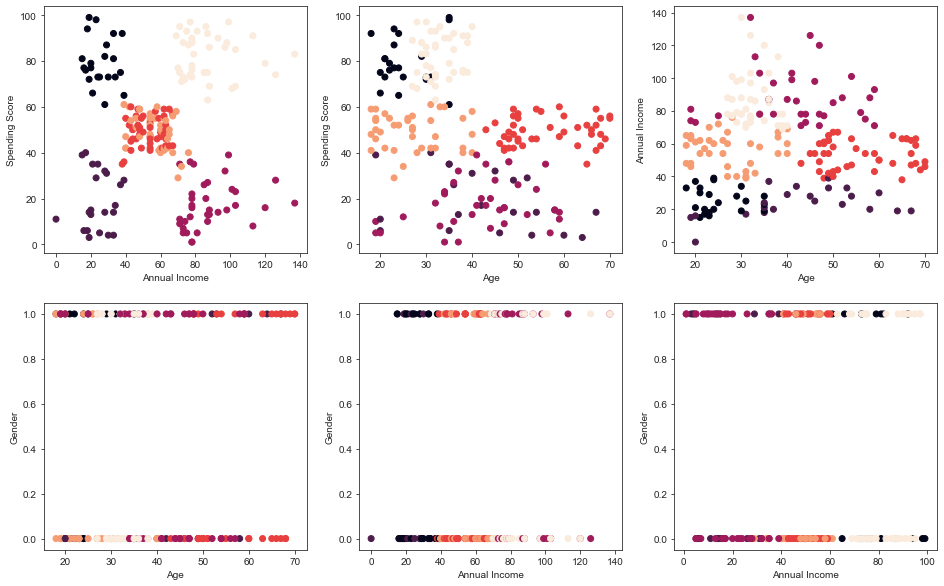

In [40]:
print_cluster_projections(X, clusters)

##### Выводы:
* По графикам видно, что наибольшее влияние на разделение кластеров оказывают Spending Score и Annual Income, на первом графике хорошо видно кластеры и скопления точек, которые их определяют;
* Spending Score и Annual Income задают 5 ярко выраженных кластеров:
1. Annual Income <= 40  и Spending Score <= 40;
2. Annual Income <= 40  и Spending Score >= 60;
3. Annual Income >= 70  и Spending Score <= 40;
4. Annual Income >= 70  и Spending Score >= 60;
5. 40 < Annual Income < 70 и 30 < Spending Score < 60 (Центральный);
* Кластеры, которые на первом графике находятся в середине и выглядят перемешанными, разделены на основе возраста (граница - 40 лет), что видно из второго и третьего графиков;
* Пол вследствие отсутствия нормализации не влияет на разделение кластеров.

**Разделение по возрасту кажется искусственным, так как исходя из Spending Score поведение данных клиентов схоже, поэтому вопреки метрике `silhouette` лучше выбрать число кластеров, равное 5.**

При этом описанные выше характеристики 5 сегментов клиентов, основанные на Spending Score и Annual Income, не изменятся.

Проведем кластеризацию с числом кластеров 5.

In [41]:
k_means = KMeans(n_clusters = 5, random_state=42)
k_means = k_means.fit(X)

clusters = k_means.labels_

Для большей наглядности построим 3D диаграмму рассеяния 5 кластеров по признакам Age, Annual Income и Spending Score.

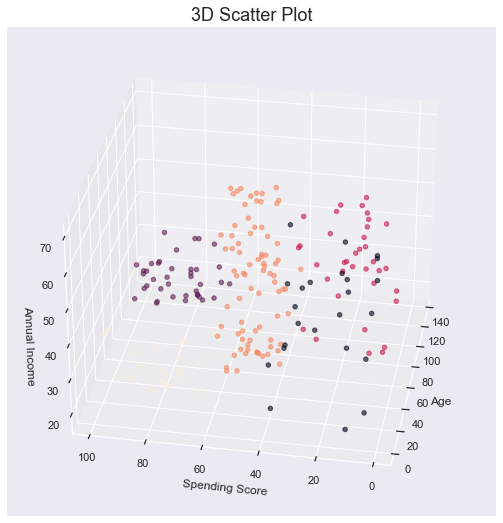

In [136]:
# Зададим размеры фигуры и трехмерное пространство
fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection='3d')
plt.title('3D Scatter Plot', fontsize=18)

ax.set_xlabel("Age")
ax.set_ylabel("Spending Score")
ax.set_zlabel("Annual Income")

# Построим диаграммы рассеяния для положительных и отрицательных кейсов
x = data["annual_income"]
y = data["spending_score"]
z = data["age"]

ax.view_init(30, 190)

ax.scatter(x, y, z, c=k_means.labels_, alpha=0.6);

Ещё раз выведем проекции кластеров на плоскости пар признаков.

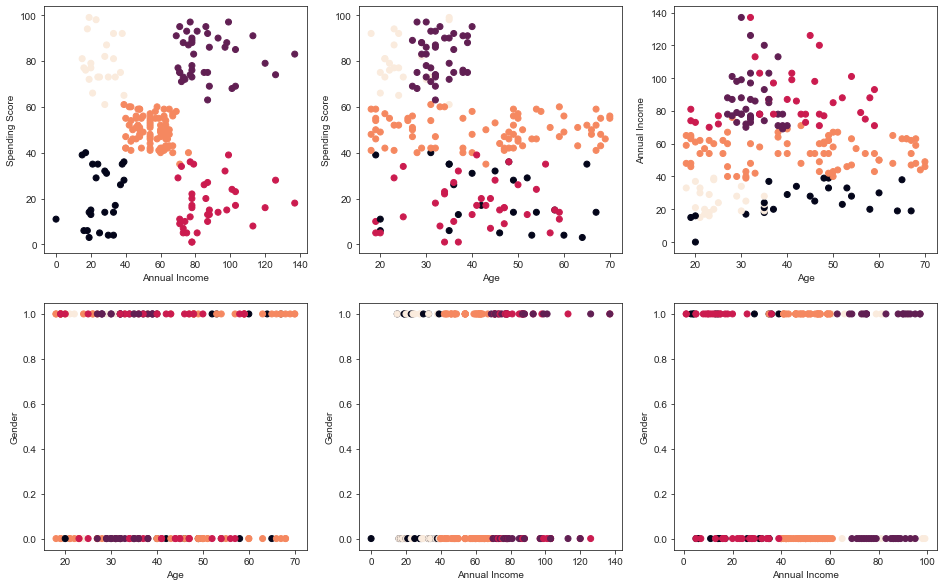

In [43]:
print_cluster_projections(X, clusters)

Продублируем выводы по 5 кластерам:
1. Annual Income <= 40  и Spending Score <= 40 (0);
2. Annual Income <= 40  и Spending Score >= 60 (4);
3. Annual Income >= 70  и Spending Score <= 40 (2);
4. Annual Income >= 70  и Spending Score >= 60 (1);
5. 40 < Annual Income < 70 и 30 < Spending Score < 60 (3 - Центральный);

В скобках указаны номера кластеров, которые будут фигурировать далее.

Выведем метрики по каждому из признаков для каждого кластера:

In [44]:
data_segmented = data.groupby(by=clusters)

In [45]:
print("Gender by cluster")
data_segmented['gender'].describe()

Gender by cluster


,count,unique,top,freq
0,24,2,Female,15
1,39,2,Female,21
2,36,2,Male,19
3,80,2,Female,47
4,22,2,Female,13


In [46]:
print("Age by cluster")
data_segmented['age'].describe()

Age by cluster


,count,mean,std,min,25%,50%,75%,max
0,24.0,44.166667,13.924226,19.0,35.00,45.5,53.25,67.0
1,39.0,32.692308,3.728650,27.0,30.00,32.0,35.50,40.0
2,36.0,40.666667,11.496583,19.0,34.00,41.5,47.25,59.0
3,80.0,42.937500,16.429630,18.0,27.00,46.5,54.25,70.0
4,22.0,25.272727,5.257030,18.0,21.25,23.5,29.75,35.0


In [47]:
print("Annual Income by cluster")
data_segmented['annual_income'].describe()

Annual Income by cluster


,count,mean,std,min,25%,50%,75%,max
0,24.0,25.208333,9.403881,0.0,19.00,24.5,33.00,39.0
1,39.0,86.538462,16.312485,69.0,75.50,79.0,95.00,137.0
2,36.0,87.750000,16.387059,70.0,77.00,83.0,97.25,137.0
3,80.0,55.087500,8.844928,39.0,48.00,54.0,62.00,76.0
4,22.0,25.727273,7.566731,15.0,19.25,24.5,32.25,39.0


In [48]:
print("Spending Score by cluster")
data_segmented['spending_score'].describe()

Spending Score by cluster


,count,mean,std,min,25%,50%,75%,max
0,24.0,20.500000,12.890846,3.0,9.75,16.0,32.75,40.0
1,39.0,82.128205,9.364489,63.0,74.50,83.0,90.00,97.0
2,36.0,17.583333,10.204691,1.0,10.00,16.0,24.50,39.0
3,80.0,49.712500,6.332943,35.0,44.75,50.0,55.00,61.0
4,22.0,79.363636,10.504174,61.0,73.00,77.0,85.75,99.0


##### Выводы:
* Наиболее многочисленным является *Центральный* кластер (3) со средними значениями дохода и метрики трат;
* *Центральный* (3) кластер включает в себя людей всех возрастов;
* Кластеры 0 и 2 также включают в себя людей разных возрастов, однако большинство старше 35 лет;
* Кластер 4 состоит из молодежи от 20 до 30 лет (среднее - 25);
* Кластер 1 состоит из людей в возрасте от 30 до 40 лет (среднее - 32);
* Во всех кластеры кроме 2 преобладают женщины;

*Остальные выводы аналогичны выводам, сделанным о 5 кластерах ранее.*

#### Агломеративная иерархическая кластеризация

Кластеризуем объекты с помощью `AgglomerativeClustering` и выведем дендрограмму кластеров.

In [145]:
model = AgglomerativeClustering(n_clusters=3)
model = model.fit(X)

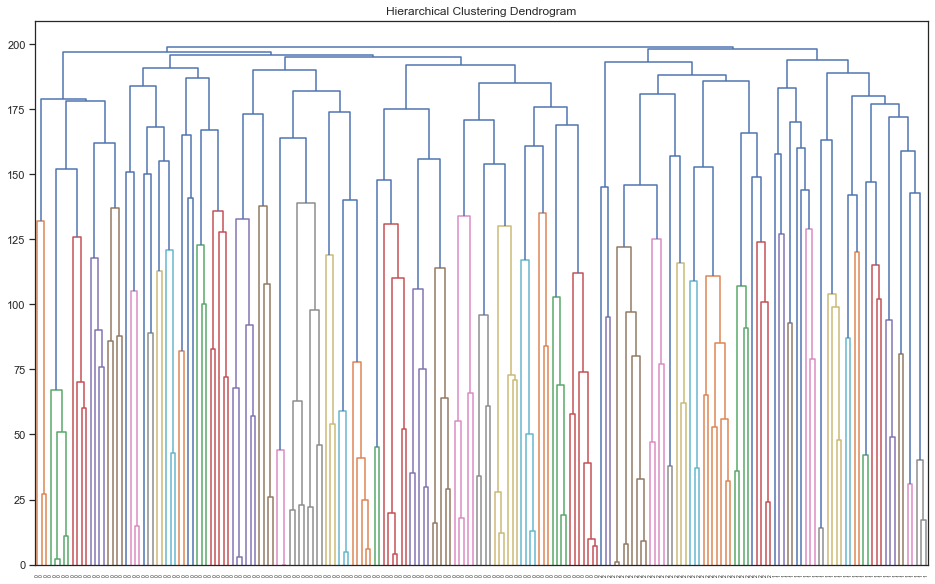

In [146]:
plt.figure(figsize=(16,10))
# Дети иерархического кластера
children = model.children_
# Для построения расстояния между детьми берем из равномерного распределения
distance = np.arange(children.shape[0])
# Число наблюдений на каждом уровне кластера
no_of_observations = np.arange(2, children.shape[0]+2)
# Строим матрицу связности
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

# Строим дендрограмму
dendrogram(linkage_matrix, labels=model.labels_)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

Исходя из дендрограммы оптимальное количество кластеров - 5 или 6 (если провести горизонталь примерно на уровне 192).

In [127]:
children

array([[ 65,  68],
       [129, 131],
       [  3,   5],
       [ 48,  49],
       [106, 109],
       [100, 105],
       [114, 115],
       [ 92,  96],
       [148, 160],
       [133, 137],
       [101, 208],
       [ 13,  15],
       [ 83,  85],
       [117, 119],
       [157, 159],
       [ 16,  20],
       [ 60,  70],
       [151, 153],
       [ 50,  56],
       [112, 121],
       [110, 205],
       [ 75,  78],
       [ 95,  97],
       [ 84,  87],
       [182, 184],
       [113, 207],
       [ 43,  51],
       [ 11,  19],
       [ 79, 213],
       [ 62,  67],
       [ 64,  72],
       [130, 136],
       [144, 150],
       [139, 210],
       [ 54,  59],
       [ 74,  80],
       [168, 174],
       [123, 127],
       [188, 192],
       [ 89, 211],
       [155, 218],
       [ 99, 226],
       [171, 173],
       [ 26,  28],
       [ 61, 201],
       [ 90, 102],
       [103, 120],
       [158, 162],
       [134, 138],
       [177, 179],
       [104, 214],
       [203, 212],
       [108,

In [128]:
linkage_matrix

array([[ 65.,  68.,   0.,   2.],
       [129., 131.,   1.,   3.],
       [  3.,   5.,   2.,   4.],
       [ 48.,  49.,   3.,   5.],
       [106., 109.,   4.,   6.],
       [100., 105.,   5.,   7.],
       [114., 115.,   6.,   8.],
       [ 92.,  96.,   7.,   9.],
       [148., 160.,   8.,  10.],
       [133., 137.,   9.,  11.],
       [101., 208.,  10.,  12.],
       [ 13.,  15.,  11.,  13.],
       [ 83.,  85.,  12.,  14.],
       [117., 119.,  13.,  15.],
       [157., 159.,  14.,  16.],
       [ 16.,  20.,  15.,  17.],
       [ 60.,  70.,  16.,  18.],
       [151., 153.,  17.,  19.],
       [ 50.,  56.,  18.,  20.],
       [112., 121.,  19.,  21.],
       [110., 205.,  20.,  22.],
       [ 75.,  78.,  21.,  23.],
       [ 95.,  97.,  22.,  24.],
       [ 84.,  87.,  23.,  25.],
       [182., 184.,  24.,  26.],
       [113., 207.,  25.,  27.],
       [ 43.,  51.,  26.,  28.],
       [ 11.,  19.,  27.,  29.],
       [ 79., 213.,  28.,  30.],
       [ 62.,  67.,  29.,  31.],
       [ 6

In [126]:
no_of_observations

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

Проведем кластеризацию с числом кластеров 5.

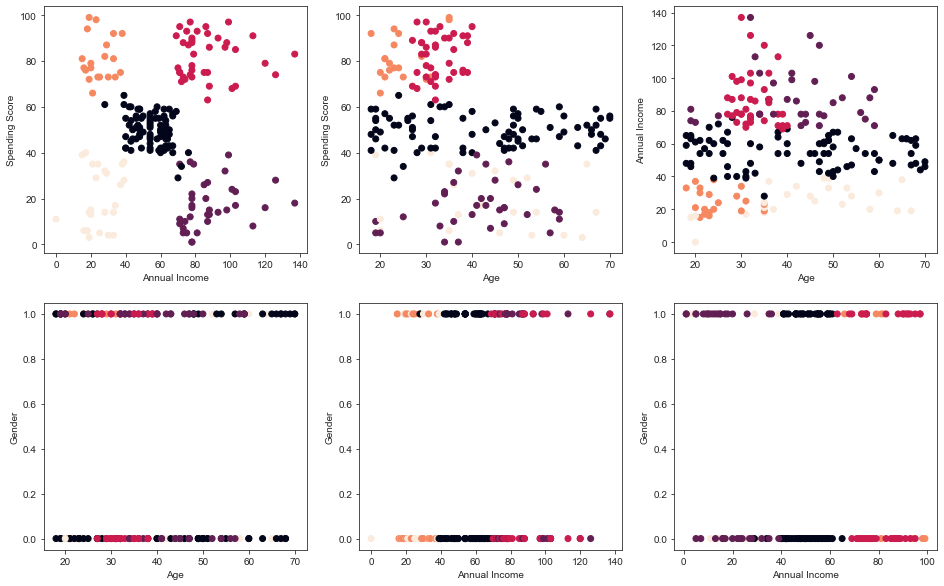

In [51]:
model = AgglomerativeClustering(n_clusters=5)
model.fit(X)
print_cluster_projections(X, model.labels_)

Судя по графикам агломеративная иерархическая кластеризация вернула тот же результат, что и K-Means.

In [52]:
data_segmented = data.groupby(by=clusters)

In [53]:
print("Gender by cluster")
data_segmented['gender'].describe()

Gender by cluster


,count,unique,top,freq
0,24,2,Female,15
1,39,2,Female,21
2,36,2,Male,19
3,80,2,Female,47
4,22,2,Female,13


In [54]:
print("Age by cluster")
data_segmented['age'].describe()

Age by cluster


,count,mean,std,min,25%,50%,75%,max
0,24.0,44.166667,13.924226,19.0,35.00,45.5,53.25,67.0
1,39.0,32.692308,3.728650,27.0,30.00,32.0,35.50,40.0
2,36.0,40.666667,11.496583,19.0,34.00,41.5,47.25,59.0
3,80.0,42.937500,16.429630,18.0,27.00,46.5,54.25,70.0
4,22.0,25.272727,5.257030,18.0,21.25,23.5,29.75,35.0


In [55]:
print("Annual Income by cluster")
data_segmented['annual_income'].describe()

Annual Income by cluster


,count,mean,std,min,25%,50%,75%,max
0,24.0,25.208333,9.403881,0.0,19.00,24.5,33.00,39.0
1,39.0,86.538462,16.312485,69.0,75.50,79.0,95.00,137.0
2,36.0,87.750000,16.387059,70.0,77.00,83.0,97.25,137.0
3,80.0,55.087500,8.844928,39.0,48.00,54.0,62.00,76.0
4,22.0,25.727273,7.566731,15.0,19.25,24.5,32.25,39.0


In [56]:
print("Spending Score by cluster")
data_segmented['spending_score'].describe()

Spending Score by cluster


,count,mean,std,min,25%,50%,75%,max
0,24.0,20.500000,12.890846,3.0,9.75,16.0,32.75,40.0
1,39.0,82.128205,9.364489,63.0,74.50,83.0,90.00,97.0
2,36.0,17.583333,10.204691,1.0,10.00,16.0,24.50,39.0
3,80.0,49.712500,6.332943,35.0,44.75,50.0,55.00,61.0
4,22.0,79.363636,10.504174,61.0,73.00,77.0,85.75,99.0


Полученные кластеры почти идентичны кластерам, полученным с помощью K-Means.

### Шаг 10. Общие выводы по проекту и рекомендации к исследованию

1. Большинство клиентов магазина женщины *(следовательно, магазину нужно рассматривать женскую клиентуру как целевую или работать на увеличение числа посетителей мужского пола)*;
2. Большинство покупателей имеют средний Spending Score;
3. Клиенты в возрасте около 30 лет чаще всего имеют высокий Spending Score *(соответственно магазину нужно привлекать больше клиентов этой возрастной категории)*;
4. Возраст и доход позволяют классифицировать высокий, средний и низкий Spending Score (но не с помощью линейной моделью, а с помощью решающего дерева, бэггинга, бустинга на деревьях или случайного леса);
5. По Spending Score и Annual Income клиенты четко делятся на 5 кластеров (такое разделение значительно превосходит разделение на 3 категории по Spending Score);
6. Самый крупный кластер состоит из людей со средним значением дохода и средним значением Spending Score - основная клиентура магазина;
7. Дополнительно самый крупный кластер можно разделить клиентов по возрасту на категории младше 40 лет и старше 40;
8. Агломеративная иерархическая кластеризация и K-Means при числе кластеров 5 выдают почти одинаковые результаты;
9. Полученные кластеры можно использовать в дальнейшем как дополнительный признак при решении задач обучения с учителем (классификации, регрессии).

Цель K средних состоит в том, чтобы сгруппировать точки данных в отдельные непересекающиеся подгруппы. Одним из основных применений K-Means кластеризации является сегментирование клиентов, чтобы лучше понять их, что, в свою очередь, может быть использовано для увеличения доходов компании.